# Sentiment analysis Eurovision Song Lyrics

In [16]:
pip install lyricsgenius
#If this doesn't work, install in a separate project

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import string

#Fro conducting Statistics
from scipy.stats import iqr
from sklearn.neighbors import KernelDensity
from statsmodels.tsa.arima.model import ARIMA
import statsmodels as sm
from scipy.stats import sem
from pmdarima.arima import auto_arima

#For Plotting
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn')

#library which will be used to count the frequency of words
from sklearn.feature_extraction.text import CountVectorizer

#To create the sentiment analysis model
import nltk
from textblob import TextBlob
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

#Genius API
from lyricsgenius import Genius
genius_token = "Your_Genius_Token"
genius = Genius(genius_token)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
df = pd.read_json("eurovision-lyrics.json").transpose()
df = df.set_index("#")
df

,Country,#.1,Artist,Song,Language,Pl.,Sc.,Eurovision_Number,Year,Host_Country,Host_City,Lyrics,Lyrics translation
#,,,,,,,,,,,,,
1,Netherlands,1,Jetty Paerl,De vogels van Holland,Dutch,-,-,1,1956,Switzerland,Lugano,De vogels van Holland zijn zo muzikaal\nZe ler...,The birds of Holland are so musical\nThey alre...
2,Switzerland,1,Lys Assia,Das alte Karussell,German,-,-,1,1956,Switzerland,Lugano,Das alte Karussell\nDas geht nicht mehr so sch...,The old carousel\nIt doesn't go as fast anymor...
3,Belgium,1,Fud Leclerc,Messieurs les noyés de la Seine,French,-,-,1,1956,Switzerland,Lugano,Messieurs les noyés de la Seine\nOuvrez-moi le...,Ye drowned men of the river Seine (1)\nOpen th...
4,Germany (West),1,Walter Andreas Schwarz,Im Wartesaal zum großen Glück,German,-,-,1,1956,Switzerland,Lugano,Es gibt einen Hafen\nDa fährt kaum ein Schiff\...,There is a harbour\nWhere hardly any ship leav...
5,France,1,Mathé Altéry,Le temps perdu,French,-,-,1,1956,Switzerland,Lugano,"Chante, carillon\nLe chant du temps perdu\nCha...","Sing, carillon\nThe song of lost time\nSing yo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1640,Sweden,60,Tusse,Voices,English,14,109,65,2021,The Netherlands,Rotterdam,There’s fire in the rain\nBut we’ll get up aga...,English
1641,Switzerland,61,Gjon's Tears,Tout l'Univers,French,3,432,65,2021,The Netherlands,Rotterdam,Laisser le vent qui frôle\nSa main sur mon épa...,Let the wind brush\nHis/her hand over my shoul...
1642,Netherlands,61,Jeangu Macrooy,Birth Of A New Age,English/Sranan Tongo,23,11,65,2021,The Netherlands,Rotterdam,Skin as rich as a starlit night\nYour rhythm i...,English


In [7]:
#the following functions clean the words which are unimportant; split the text into discrete words;
#created new column to group songs and lyrics by decades

def clean_lyrics(df,column):
 
    df = df
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
    df[column] = df[column].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
    df[column] = df[column].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+","").str.replace("efil ym fo flah","")
    df[column] = df[column].str.strip()

    return df

def lyrics_to_words(document):
   
    stop_words = set(stopwords.words('english'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    stopwordremoval = " ".join([i for i in document.lower().split() if i not in stop_words])
    punctuationremoval = ''.join(ch for ch in stopwordremoval if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punctuationremoval.split())
    return normalized

def create_decades(df):
   
    decades = []

    for year in df['Year']:
        if 1950 <= int(year) < 1960:
            decades.append("50s")
        if 1960 <= int(year) < 1970:
            decades.append("60s")
        if 1970 <= int(year) < 1980:
            decades.append("70s")
        if 1980 <= int(year) < 1990:
            decades.append("80s")
        if 1990 <= int(year) < 2000:
            decades.append("90s")
        if 2000 <= int(year) < 2010:
            decades.append("00s")
        if 2010 <= int(year) :
            decades.append("10s")
    df['Decade'] = decades
    df = df[['Country','#.1','Artist','Song','Language','Pl.','Sc.', 'Eurovision_Number', 'Year', 'Decade', 'Host_Country', 'Host_City', 'Lyrics', 'Lyrics translation']]
    return df

def unique(list1):
   # intilize a null list
     unique_list = []
   # traverse for all elements
     for x in list1:
         # check if exists in unique_list or not
         if x not in unique_list:
              unique_list.append(x)
     return unique_list

def word_stats(df_list, main_df):
  unique_words = []
  total_words =  []
  total_news = []
  years = []

  for decade_df in df_list:
    for value in decade_df.columns[1:]:
      unique_words.append(np.count_nonzero(decade_df[value]))
      total_words.append(sum(decade_df[value].tolist()))
      years.append(str(value))
      total_news.append(main_df['Decade'][main_df['Decade']==value].count())
  data = pd.DataFrame({'decade':years, 'unique words':unique_words,'total words':total_words,'total songs':total_news})
  data['words per songs'] = round(data['total words'] / data['total songs'],0)
  data['words per songs'] = data['words per songs'].astype('int')
  return data 

In [8]:
df = clean_lyrics(df, "Lyrics")
df = clean_lyrics(df, "Lyrics translation")

/var/folders/5k/fllrdymj0cgfdpg6yw3nv_z80000gn/T/ipykernel_20249/3210090712.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
/var/folders/5k/fllrdymj0cgfdpg6yw3nv_z80000gn/T/ipykernel_20249/3210090712.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column] = df[column].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
/var/folders/5k/fllrdymj0cgfdpg6yw3nv_z80000gn/T/ipykernel_20249/3210090712.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df[column] = df[column].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
/var/folders/5k/fllrdymj0cgfdpg6yw3n

In [9]:
df= df[df['Lyrics'].notnull()]
df = df[df['Lyrics translation'].notnull()]
df = create_decades(df)

In [10]:
#proceeds unique words of each song into a new column which is called words
#list is used to store the words
words = []
#iterate trought each lyric and split unique words appending the result into the words list
df = df.reset_index(drop=True)
for word in df['Lyrics'].tolist():
    words.append(unique(lyrics_to_words(word).split()))
#create the new column with the words lists
df['words'] = words
df.head()

,Country,#.1,Artist,Song,Language,Pl.,Sc.,Eurovision_Number,Year,Decade,Host_Country,Host_City,Lyrics,Lyrics translation,words
0,Netherlands,1,Jetty Paerl,De vogels van Holland,Dutch,-,-,1,1956,50s,Switzerland,Lugano,de vogels van holland zijn zo muzikaal ze lere...,the birds of holland are so musical they alrea...,"[de, vogels, van, holland, zijn, zo, muzikaal,..."
1,Switzerland,1,Lys Assia,Das alte Karussell,German,-,-,1,1956,50s,Switzerland,Lugano,das alte karussell das geht nicht mehr so schn...,the old carousel it doesn't go as fast anymore...,"[da, alte, karussell, geht, nicht, mehr, schne..."
2,Belgium,1,Fud Leclerc,Messieurs les noyés de la Seine,French,-,-,1,1956,50s,Switzerland,Lugano,messieurs les noyés de la seine ouvrezmoi les ...,ye drowned men of the river seine open the wa...,"[monsieur, le, noyés, de, la, seine, ouvrezmoi..."
3,Germany (West),1,Walter Andreas Schwarz,Im Wartesaal zum großen Glück,German,-,-,1,1956,50s,Switzerland,Lugano,es gibt einen hafen da fährt kaum ein schiff u...,there is a harbour where hardly any ship leave...,"[e, gibt, einen, hafen, da, fährt, kaum, ein, ..."
4,France,1,Mathé Altéry,Le temps perdu,French,-,-,1,1956,50s,Switzerland,Lugano,chante carillon le chant du temps perdu chante...,sing carillon the song of lost time sing your ...,"[chante, carillon, le, chant, du, temp, perdu,..."


In [11]:
languages = ['english', 'german', 'spanish', 'french', 'dutch', 'italian', 'danish', 'swedish', 'finnish', 'slovene', 'greek', 'turkish', 'arabic', 'romanian', 'hungarian', 'russian']


In [12]:
#Create a list of stop words of all languages included in nltk package.
stop_words = []
for language in languages:
  stop_words.extend(stopwords.words(language))
stop_words.extend(["oh", "cest"]) #These words appear a lot but don't add any meaning

#Split the dataset into decades
decades = ['50s', '60s', '70s', '80s', '90s', '00s', '10s']
df_decade_list = []
for decade in decades:
  df_decade_list.append(df[df['Decade'] == decade])

#Create a data_frame of words used per decade
df_word_list = [] 
for decade_df, decade_choice in zip(df_decade_list, decades):
  set_words = []
  set_decades = []
  for i in decade_df.index:
    for word in decade_df['words'].loc[i]:
      if word == 'lamour':
        set_words.append('amour') #replace l'amour with amour
      else:
        set_words.append(word)
      set_decades.append(decade_df['Decade'].loc[i])
  words_df = pd.DataFrame({'words':set_words, 'decade':set_decades})

#Count the word frequencies per decade and place them into a list of datasets per decade
  cv = CountVectorizer(stop_words = stop_words)
  text_cv = cv.fit_transform(words_df['words'])
  data_cv = pd.DataFrame(text_cv.toarray(), columns=cv.get_feature_names())
  data_cv['decade'] = words_df['decade']
  vect_words = data_cv.groupby('decade').sum().T
  vect_words = vect_words.reset_index(level=0).rename(columns = {'index':'words'})
  vect_words = vect_words.rename_axis(columns='')
  vect_words = vect_words[['words', decade_choice]]
  df_word_list.append(vect_words)

/Users/deryaengin/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['printr', 'δι', 'آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء', 'ἀλλ'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [13]:
#Create a list of stop words of all languages included in nltk package.
stop_words = []
for language in languages:
  stop_words.extend(stopwords.words(language))
stop_words.extend(["oh", "cest"]) #These words appear a lot but don't add any meaning

#Split the dataset into decades
decades = ['50s', '60s', '70s', '80s', '90s', '00s', '10s']
df_decade_list = []
for decade in decades:
  df_decade_list.append(df[df['Decade'] == decade])

#Create a data_frame of words used per decade
df_word_list = [] 
for decade_df, decade_choice in zip(df_decade_list, decades):
  set_words = []
  set_decades = []
  for i in decade_df.index:
    for word in decade_df['words'].loc[i]:
      if word == 'lamour':
        set_words.append('amour') #replace l'amour with amour
      else:
        set_words.append(word)
      set_decades.append(decade_df['Decade'].loc[i])
  words_df = pd.DataFrame({'words':set_words, 'decade':set_decades})

#Count the word frequencies per decade and place them into a list of datasets per decade
  cv = CountVectorizer(stop_words = stop_words)
  text_cv = cv.fit_transform(words_df['words'])
  data_cv = pd.DataFrame(text_cv.toarray(), columns=cv.get_feature_names())
  data_cv['decade'] = words_df['decade']
  vect_words = data_cv.groupby('decade').sum().T
  vect_words = vect_words.reset_index(level=0).rename(columns = {'index':'words'})
  vect_words = vect_words.rename_axis(columns='')
  vect_words = vect_words[['words', decade_choice]]
  df_word_list.append(vect_words)

In [14]:
for decade_choice, i in zip(decades, range(len(decades))):
  print("The Most Popular Word of the {} is {}".format(decade_choice, df_word_list[i]['words'].iloc[df_word_list[i][decades[i]].idxmax()]))

The Most Popular Word of the 50s is amour
The Most Popular Word of the 60s is amour
The Most Popular Word of the 70s is amour
The Most Popular Word of the 80s is vie
The Most Popular Word of the 90s is love
The Most Popular Word of the 00s is love
The Most Popular Word of the 10s is love


In [15]:
#Create lists to store the different scores for each set of lyrics
sentiment = []
#Iterate for each row of lyrics and append the scores
for i in df.index:
  #Create text blobs for each of the song lyrics
  if df['Lyrics translation'].iloc[i] == "english":
    blob=TextBlob(df['Lyrics'].iloc[i])
  else:
    blob=TextBlob(df['Lyrics translation'].iloc[i])
  sentiment.append(blob.sentiment[0])
#Create a column for the sentiment score
df['sentiment'] = sentiment
df.head()

,Country,#.1,Artist,Song,Language,Pl.,Sc.,Eurovision_Number,Year,Decade,Host_Country,Host_City,Lyrics,Lyrics translation,words,sentiment
0,Netherlands,1,Jetty Paerl,De vogels van Holland,Dutch,-,-,1,1956,50s,Switzerland,Lugano,de vogels van holland zijn zo muzikaal ze lere...,the birds of holland are so musical they alrea...,"[de, vogels, van, holland, zijn, zo, muzikaal,...",0.138021
1,Switzerland,1,Lys Assia,Das alte Karussell,German,-,-,1,1956,50s,Switzerland,Lugano,das alte karussell das geht nicht mehr so schn...,the old carousel it doesn't go as fast anymore...,"[da, alte, karussell, geht, nicht, mehr, schne...",0.059755
2,Belgium,1,Fud Leclerc,Messieurs les noyés de la Seine,French,-,-,1,1956,50s,Switzerland,Lugano,messieurs les noyés de la seine ouvrezmoi les ...,ye drowned men of the river seine open the wa...,"[monsieur, le, noyés, de, la, seine, ouvrezmoi...",-0.027151
3,Germany (West),1,Walter Andreas Schwarz,Im Wartesaal zum großen Glück,German,-,-,1,1956,50s,Switzerland,Lugano,es gibt einen hafen da fährt kaum ein schiff u...,there is a harbour where hardly any ship leave...,"[e, gibt, einen, hafen, da, fährt, kaum, ein, ...",0.184144
4,France,1,Mathé Altéry,Le temps perdu,French,-,-,1,1956,50s,Switzerland,Lugano,chante carillon le chant du temps perdu chante...,sing carillon the song of lost time sing your ...,"[chante, carillon, le, chant, du, temp, perdu,...",0.310317


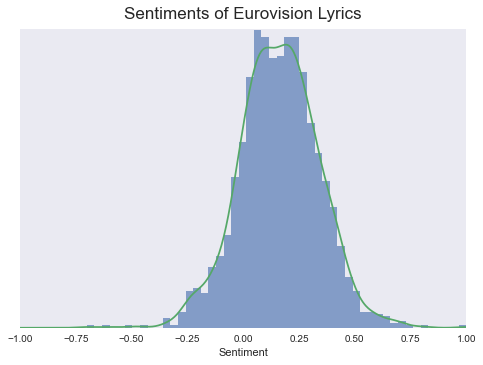

In [16]:
fig, ax = plt.subplots()

#define histograms and kde
df["sentiment"].plot(kind="hist", density=True, bins=50, alpha=0.65)
df["sentiment"].plot(kind="kde")

#Appearance settings
ax.set_xlabel("Sentiment")
ax.set_xlim(-1, 1)
ax.set_ylim(0,2.3)
ax.set_yticks([])
ax.set_ylabel("")
ax.set_title("Sentiments of Eurovision Lyrics", size=17, pad=10)
ax.tick_params(left=False, bottom=False)
plt.style.use("bmh")
ax.grid(False)
for ax, spine in ax.spines.items():
  spine.set_visible(False)


plt.show()

In [17]:
df_decade = []
for d in decades:
  df_decade.append(df[df['Decade'] == d])

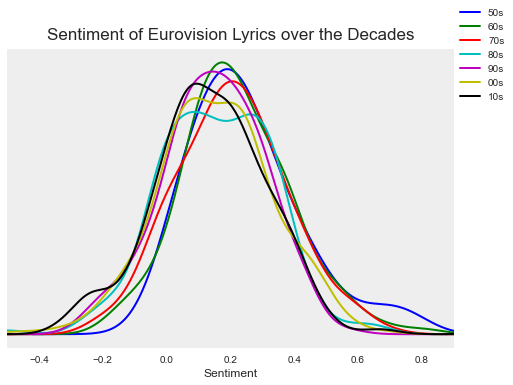

In [18]:
fig, ax = plt.subplots()
colors = "bgrcmyk"
#Print a KDE for each decade
for data, decade_c, c in zip(df_decade, decades, colors):
  data["sentiment"].plot(kind="kde", c=c, label=decade_c)
#Appearance settings
ax.set_xlabel("Sentiment")
ax.set_xlim(-0.5, 0.9)
ax.grid(False)
ax.set_xlabel("Sentiment")
ax.set_yticks([])
ax.set_ylabel("")
ax.set_title("Sentiment of Eurovision Lyrics over the Decades", size=17, pad=10)
plt.style.use("bmh")
for ax, spine in ax.spines.items():
  spine.set_visible(False)
fig.legend()
plt.show()

In [19]:
#Find means and confidence intervals for each decade
CIs = []
means = []
for data in df_decade:
  means.append(np.mean(data['sentiment']))
  CIs.append([round(np.mean(data['sentiment'])-1.96*sem(data['sentiment']),3), round(np.mean(data['sentiment'])+1.96*sem(data['sentiment']),3)])

#Print these
for d, c, m in zip(decades,CIs,means):
  print("The mean for the {} is: {}".format(d,round(m,2)))
  print("The CI for the {} is: {}".format(d, c))


The mean for the 50s is: 0.25
The CI for the 50s is: [0.196, 0.298]
The mean for the 60s is: 0.22
The CI for the 60s is: [0.195, 0.247]
The mean for the 70s is: 0.2
The CI for the 70s is: [0.178, 0.229]
The mean for the 80s is: 0.16
The CI for the 80s is: [0.132, 0.18]
The mean for the 90s is: 0.15
The CI for the 90s is: [0.127, 0.167]
The mean for the 00s is: 0.15
The CI for the 00s is: [0.13, 0.17]
The mean for the 10s is: 0.14
The CI for the 10s is: [0.121, 0.153]
